In [ ]:
! pip install "everywhereml>=0.2.32"

# ONE CLASS SVM MODEL


=== Evaluation Metrics ===
Confusion Matrix:
[[  0   0]
 [ 18 482]]

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.00      0.00      0.00         0
  Legitimate       1.00      0.96      0.98       500

    accuracy                           0.96       500
   macro avg       0.50      0.48      0.49       500
weighted avg       1.00      0.96      0.98       500


Overall Accuracy: 0.96

=== Evaluation Metrics ===
Confusion Matrix:
[[  0   0]
 [126 374]]

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.00      0.00      0.00         0
  Legitimate       1.00      0.75      0.86       500

    accuracy                           0.75       500
   macro avg       0.50      0.37      0.43       500
weighted avg       1.00      0.75      0.86       500


Overall Accuracy: 0.75


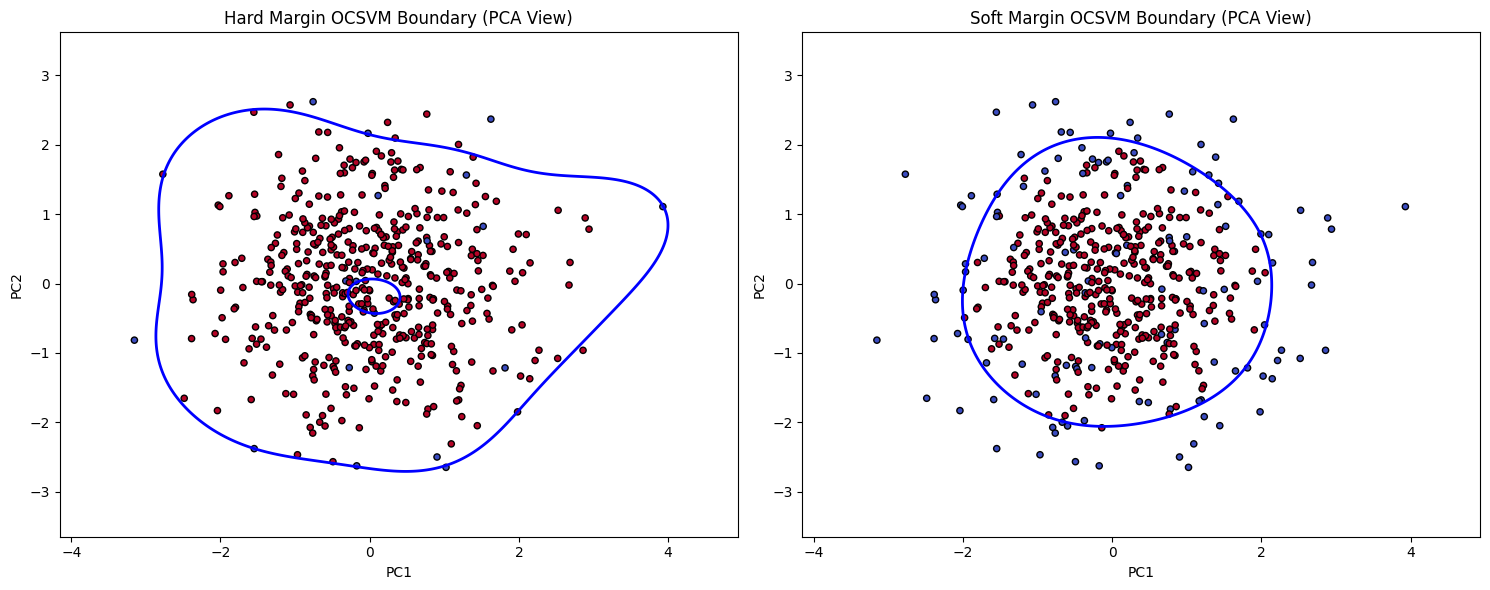

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import seaborn as sns

# Load the dataset
df = pd.read_csv("Transaction_data.csv")

# Select features and labels
features = ['pitch_deg', 'roll_deg', 'response_time_ms']
X = df[features]

has_labels = 'label' in df.columns
if has_labels:
    y_true = df['label'].map({'Legitimate': 1, 'Anomaly': -1})  # Standardize labels

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Define estimators
estimators = {
    "Hard Margin OCSVM": OneClassSVM(nu=0.02, gamma='scale'),
    "Soft Margin OCSVM": OneClassSVM(nu=0.25, gamma='scale')
}

# Plotting and evaluation setup
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 500),
                     np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 500))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Fit and visualize each model
for ax, (name, model) in zip(axs, estimators.items()):
    model.fit(X_scaled)
    y_pred = model.predict(X_scaled)

    # Evaluate if labels are available
    if has_labels:
    # Step 1: Convert string labels to numeric
      label_map = {'legitimate': 1, 'anomaly': -1}
      y_true_mapped = df['label'].str.lower().map(label_map)

    # Step 2: Now evaluate
    print("\n=== Evaluation Metrics ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true_mapped, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_true_mapped, y_pred, zero_division=0,target_names=['Anomaly', 'Legitimate']))

    accuracy = accuracy_score(y_true_mapped, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.2f}")

    # Fit decision boundary in PCA space
    Z = model.decision_function(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='blue')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='coolwarm', edgecolors='k', s=20)
    ax.set_title(f"{name} Boundary (PCA View)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()


In [ ]:
pip install joblib

In [ ]:
import joblib
from sklearn.svm import OneClassSVM
# Save model parameters
sv_indices = model.support_
sv_coef = model.dual_coef_[0]
sv_vectors = model.support_vectors_
rho = model.intercept_[0]
gamma = model._gamma  # RBF kernel parameter

# Export to dictionary
model_params = {
    'sv_vectors': sv_vectors.tolist(),
    'sv_coef': sv_coef.tolist(),
    'rho': rho,
    'gamma': gamma,
    'n_sv': len(sv_indices),
    'n_features': X_train.shape[1]
}

joblib.dump(model_params, 'model_params.pkl')

['model_params.pkl']

#AUTO ENCODER


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

=== Autoencoder (Tight) Evaluation Metrics ===
Confusion Matrix:
[[  0   0]
 [ 15 485]]

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.00      0.00      0.00         0
  Legitimate       1.00      0.97      0.98       500

    accuracy                           0.97       500
   macro avg       0.50      0.48      0.49       500
weighted avg       1.00      0.97      0.98       500


Overall Accuracy: 0.97
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step

=== Autoencoder (Loose) Evaluation Metrics ===
Confusion Matrix:
[[  0   0]
 [ 50 450]]

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.00      0.00      0.00         0
  Legitimate       1.00      0.90      0.95       500

    accuracy                           0.90       500
   macro avg       0.50      0.45      0.47       500
weighted avg       1.00      0.90      0.95       500


Overall Accu

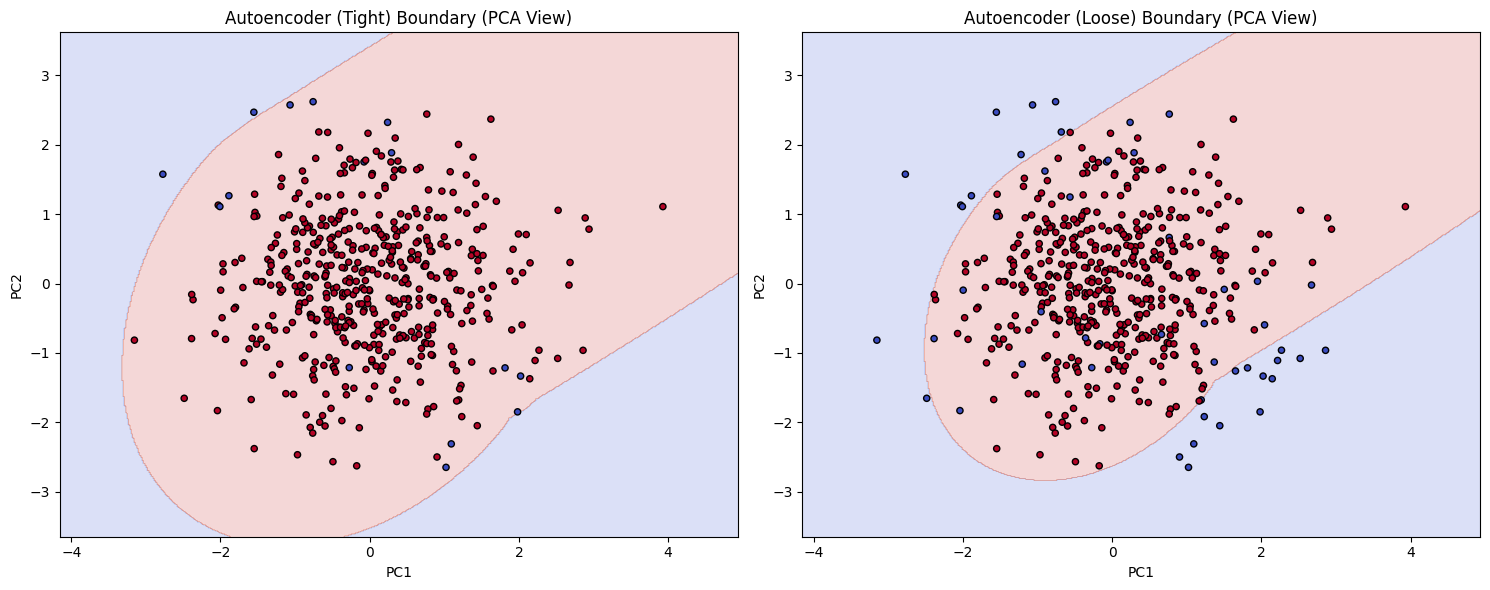

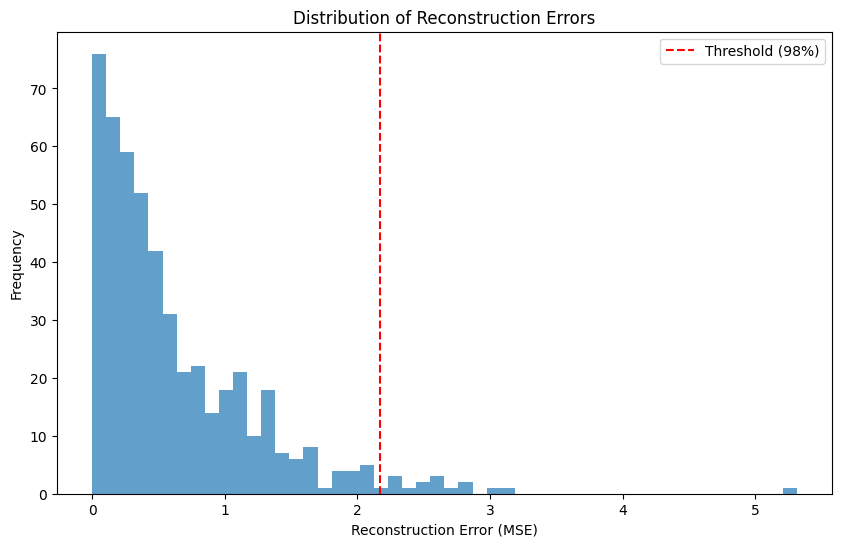

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Load the dataset
df = pd.read_csv("Transaction_data.csv")

# Select features and labels
features = ['pitch_deg', 'roll_deg', 'response_time_ms']
X = df[features]

has_labels = 'label' in df.columns
if has_labels:
    y_true = df['label'].map({'Legitimate': 1, 'Anomaly': -1})  # Standardize labels

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Define Autoencoder model
input_dim = X_scaled.shape[1]
encoding_dim = 2  # Bottleneck layer size

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim*2, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu")(encoder)

# Decoder
decoder = Dense(encoding_dim*2, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(X_scaled, X_scaled,
                         epochs=50,
                         batch_size=32,
                         shuffle=True,
                         validation_split=0.1,
                         verbose=0)

# Get reconstruction errors
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Convert reconstruction errors to predictions (1 = normal, -1 = anomaly)
threshold = np.quantile(mse, 0.97)  # Adjust based on expected anomaly rate
y_pred = np.where(mse > threshold, -1, 1)

# Define estimators dictionary for compatibility with existing visualization
estimators = {
    "Autoencoder (Tight)": {"pred": y_pred, "threshold": np.quantile(mse, 0.98)},
    "Autoencoder (Loose)": {"pred": np.where(mse > np.quantile(mse, 0.90), -1, 1), "threshold": np.quantile(mse, 0.90)}
}

# Plotting and evaluation setup
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 500),
                     np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 500))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Fit and visualize each model
for ax, (name, model_info) in zip(axs, estimators.items()):
    y_pred = model_info["pred"]

    # Evaluate if labels are available
    if has_labels:
        # Step 1: Convert string labels to numeric
        label_map = {'legitimate': 1, 'anomaly': -1}
        y_true_mapped = df['label'].str.lower().map(label_map)

        # Step 2: Now evaluate
        print(f"\n=== {name} Evaluation Metrics ===")
        print("Confusion Matrix:")
        print(confusion_matrix(y_true_mapped, y_pred))

        print("\nClassification Report:")
        print(classification_report(y_true_mapped, y_pred, zero_division=0, target_names=['Anomaly', 'Legitimate']))

        accuracy = accuracy_score(y_true_mapped, y_pred)
        print(f"\nOverall Accuracy: {accuracy:.2f}")

    # Create decision boundary visualization in PCA space
    grid_points = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    reconstructions_grid = autoencoder.predict(grid_points)
    mse_grid = np.mean(np.square(grid_points - reconstructions_grid), axis=1)
    Z = np.where(mse_grid > model_info["threshold"], -1, 1)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='coolwarm', edgecolors='k', s=20)
    ax.set_title(f"{name} Boundary (PCA View)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()

# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold (98%)')
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.show()

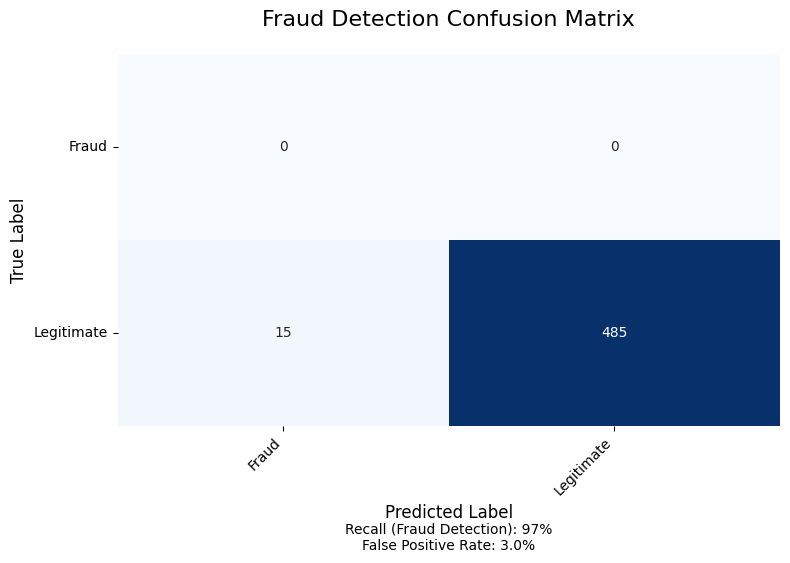

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your confusion matrix data
cm = np.array([[  0,   0],
 [ 15, 485]])

# Class labels
classes = ['Fraud', 'Legitimate']

# Create figure
plt.figure(figsize=(8, 6))

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar=False)

# Add labels and title
plt.title('Fraud Detection Confusion Matrix', pad=20, fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Customize tick marks
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Annotate performance metrics
plt.text(0.5, -0.3,
         f"Recall (Fraud Detection): 97%\nFalse Positive Rate: {15/500*100:.1f}%",
         ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


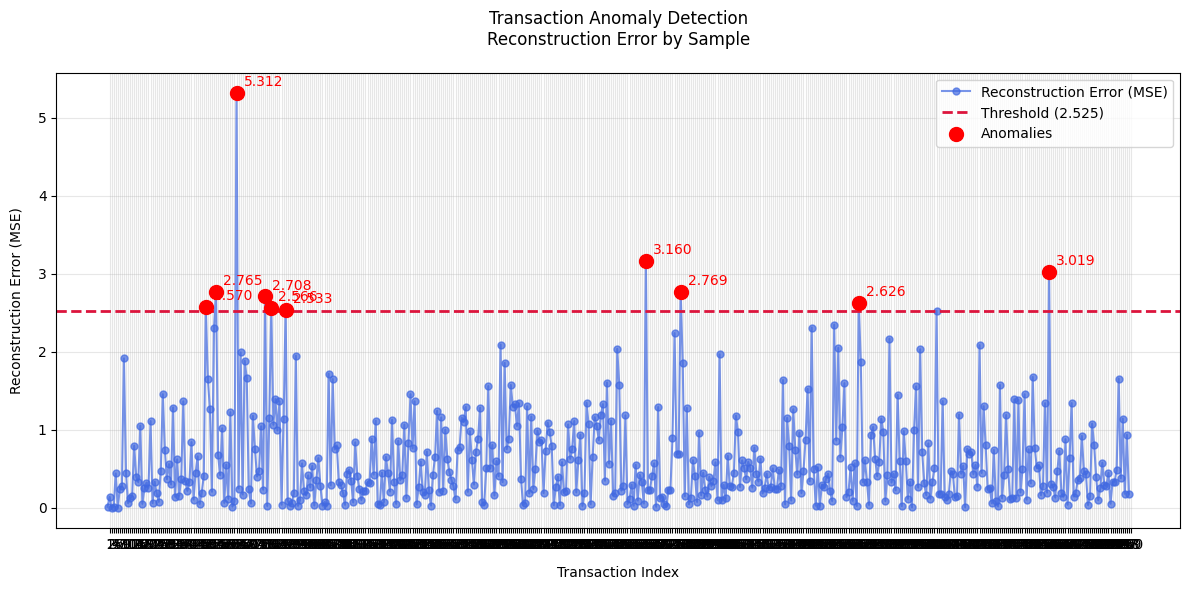

In [ ]:
# Reconstruction Error Visualization
plt.figure(figsize=(12, 6))

# Plot reconstruction errors
plt.plot(mse, 'o-', color='royalblue', markersize=5,
         label='Reconstruction Error (MSE)', alpha=0.7)

# Add threshold line
threshold = np.quantile(mse, 0.98)  # Using 98th percentile
plt.axhline(y=threshold, color='crimson', linestyle='--',
            linewidth=2, label=f'Threshold ({threshold:.3f})')

# Highlight anomalies
anomaly_indices = np.where(mse > threshold)[0]
plt.scatter(anomaly_indices, mse[anomaly_indices],
            color='red', s=100, label='Anomalies', zorder=5)

# Formatting
plt.title('Transaction Anomaly Detection\nReconstruction Error by Sample', pad=20)
plt.xlabel('Transaction Index', labelpad=10)
plt.ylabel('Reconstruction Error (MSE)', labelpad=10)
# The step argument should be an integer. Here, we set it to 1 to have ticks for every data point.
plt.xticks(np.arange(1, len(mse)+1, 1))  # Start index at 1, step of 1
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Add data labels for anomalies
for i in anomaly_indices:
    plt.annotate(f'{mse[i]:.3f}',
                 xy=(i, mse[i]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 color='red')

plt.tight_layout()
plt.show()

Text(0.95, 0.05, 'Accuracy: 90.00%')

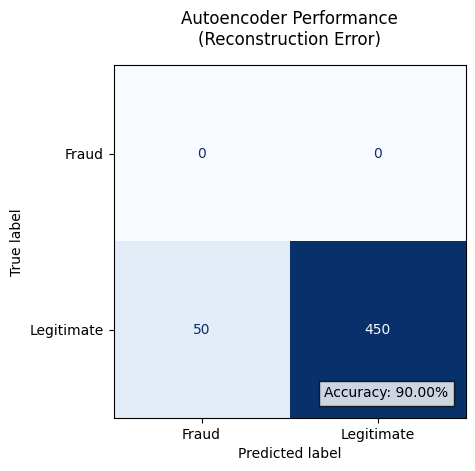

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# For Autoencoder
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_predictions(
    y_true_mapped,
    y_pred,  # Autoencoder predictions
    display_labels=['Fraud', 'Legitimate'],
    cmap='Blues',
    ax=ax1,
    colorbar=False
)
ax1.set_title('Autoencoder Performance\n(Reconstruction Error)', pad=15)
ax1.grid(False)

# Add accuracy annotation
accuracy_ae = accuracy_score(y_true_mapped, y_pred)
ax1.text(0.95, 0.05, f'Accuracy: {accuracy_ae:.2%}',
        ha='right', va='bottom', transform=ax1.transAxes,
        bbox=dict(facecolor='white', alpha=0.8))

In [ ]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpk5jn3mmc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136873898929104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873898929488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800100240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800097552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800097936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800090064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800096208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800090256: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Integer quantization (helps size and makes it MCU-compatible)
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Required: representative dataset for quantization
def representative_data_gen():
    for i in range(100):
        yield [X_scaled[i:i+1].astype(np.float32)]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

# Save the quantized model
with open("autoencoder_model_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)


Saved artifact at '/tmp/tmp3e9pwj1w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136873898929104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873898929488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800100240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800097552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800097936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800090064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800096208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136873800090256: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')